# Swish-based classifier using cosine-annealed LR with restarts and data augmentation
- Swish activation, 4 layers, 100 neurons per layer
- LR using cosine-annealing with restarts and cycle multiplicity of 2
- Data is augmentaed via phi rotations, and transvers and longitudinal flips
- Validation score use ensemble of 10 models weighted by loss

### Import modules

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
from __future__ import division
import sys
import os
sys.path.append('../')
from modules.basics import *
from modules.class_basics import *

Using TensorFlow backend.


## Options

In [2]:
with open(DATA_PATH/'feats.pkl', 'rb') as fin:
    train_feats = pickle.load(fin)
    train_feats = [var for x in train_feats for var in train_feats[x]]

In [3]:
n_models = 10
patience = 2
max_epochs = 200

ensemble_size = 10
ensemble_mode = 'loss'

compile_args = {'loss':'binary_crossentropy', 'optimizer':'adam', 'res':[2], 'trainable':True, 'bn':'post'}
train_params = {'epochs' : 1, 'batch_size' : 256, 'verbose' : 0}
model_params = {'version':'modelSwishRes', 'n_in':len(train_feats), 'compile_args':compile_args, 'mode':'classifier'}

print ("\nTraining on", len(train_feats), "features:", [var for var in train_feats])


Training on 31 features: ['DER_mass_MMC', 'DER_mass_transverse_met_lep', 'DER_mass_vis', 'DER_pt_h', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet', 'DER_prodeta_jet_jet', 'DER_deltar_tau_lep', 'DER_pt_tot', 'DER_sum_pt', 'DER_pt_ratio_lep_tau', 'DER_met_phi_centrality', 'DER_lep_eta_centrality', 'PRI_met_pt', 'PRI_met_sumet', 'PRI_jet_num', 'PRI_jet_all_pt', 'PRI_tau_px', 'PRI_tau_py', 'PRI_tau_pz', 'PRI_lep_px', 'PRI_lep_py', 'PRI_lep_pz', 'PRI_jet_leading_px', 'PRI_jet_leading_py', 'PRI_jet_leading_pz', 'PRI_jet_subleading_px', 'PRI_jet_subleading_py', 'PRI_jet_subleading_pz', 'PRI_met_px', 'PRI_met_py']


## Import data

In [4]:
train_fy = HEPAugFoldYielder(train_feats, h5py.File(DATA_PATH/'train.hdf5', "r+"), rot_mult=2)

Augmenting via phi rotations
Augmenting via y flips
Augmenting via longitunidnal flips
Total augmentation multiplicity is 8


/Users/giles/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:448: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())
/Users/giles/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:448: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


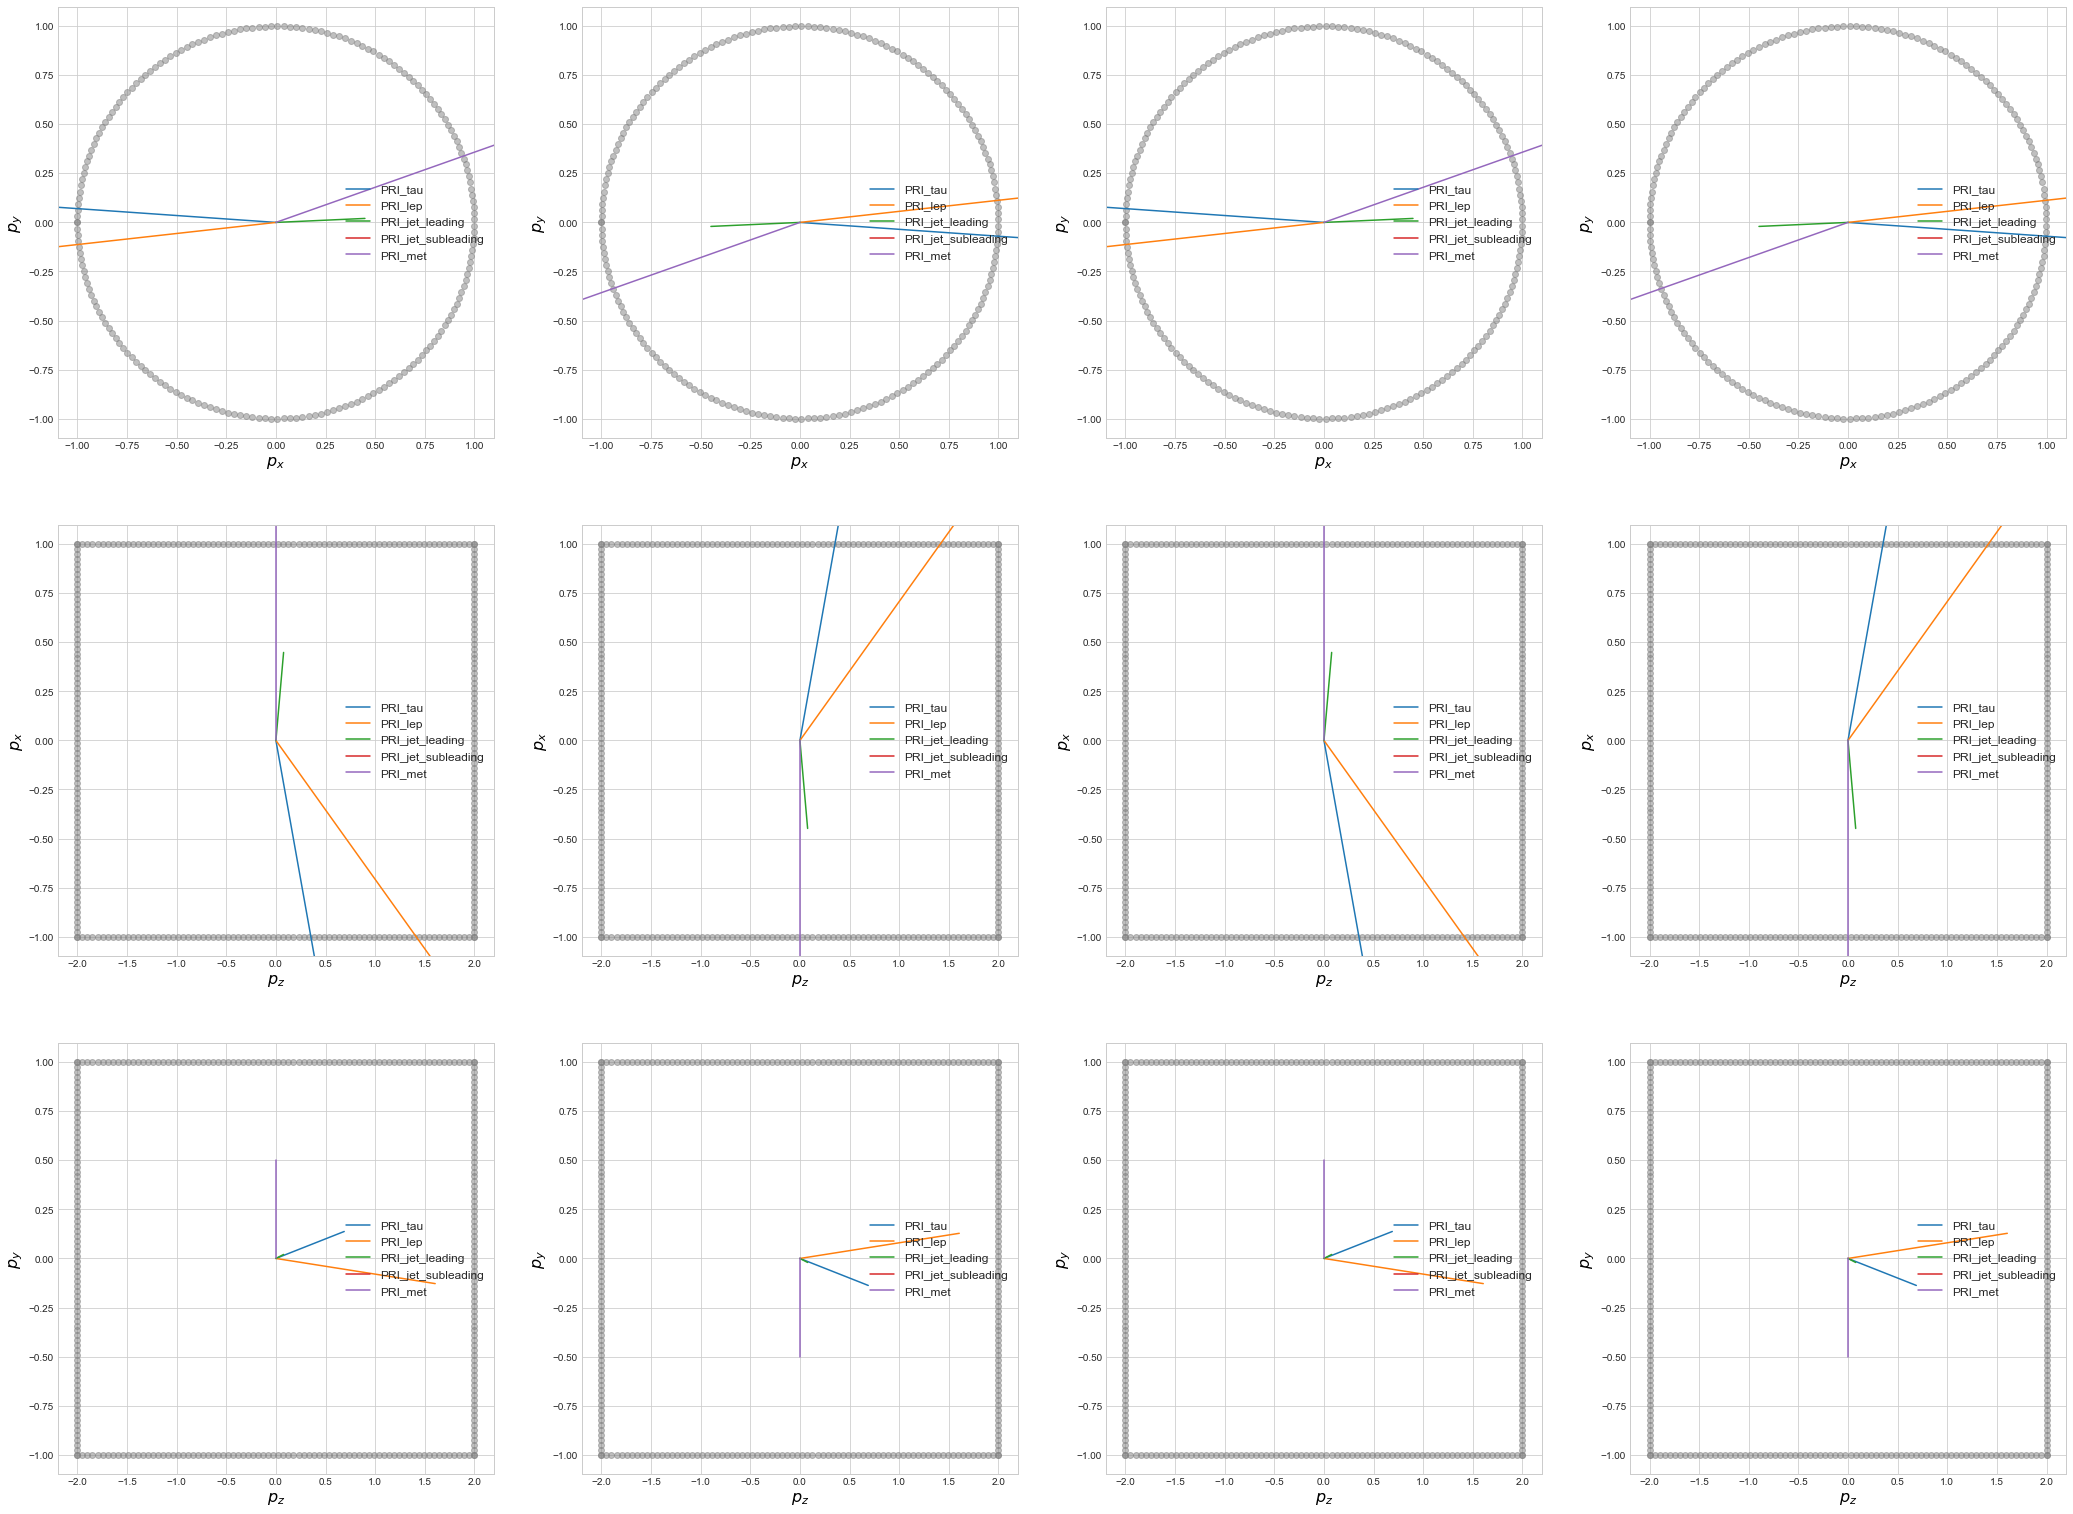

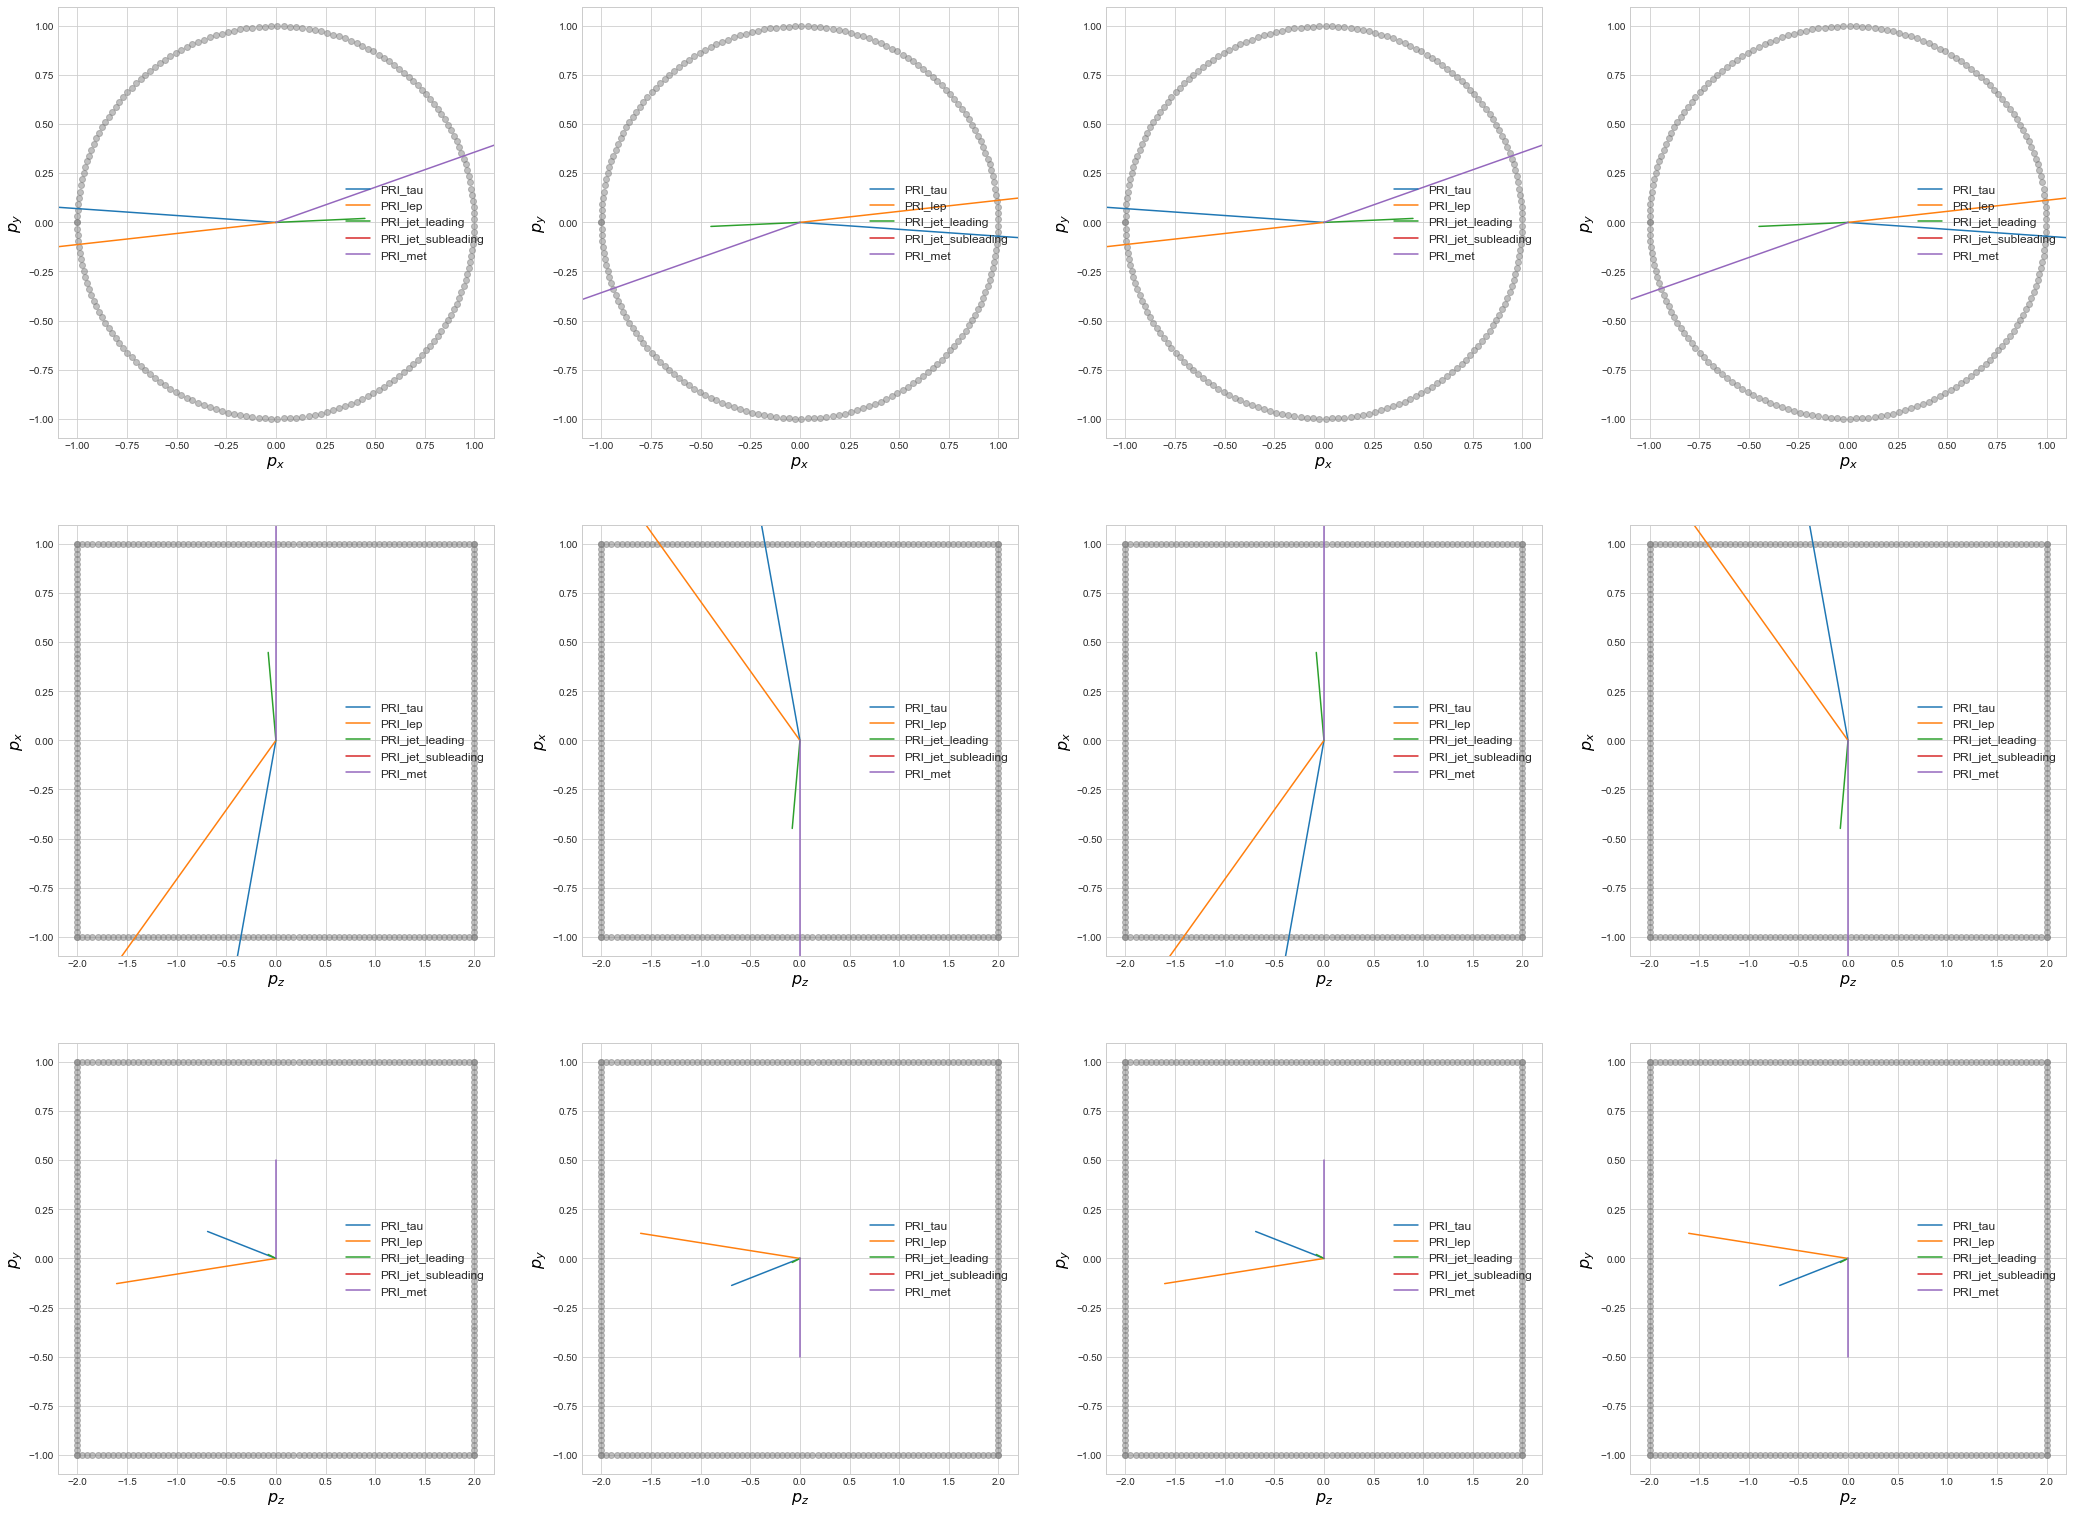

In [6]:
id=3
aug_ranges = [range(4), range(4,8)]
for aug_range in aug_ranges:
    comp_events([pd.DataFrame(train_fy.get_test_fold(0, i)['inputs'], columns=train_feats)[id:id+1] for i in aug_range])

In [5]:
from __future__ import division

from keras.models import Sequential, Model
from keras.layers import Dense, Activation, AlphaDropout, Dropout, BatchNormalization, add, Embedding, Reshape, Input
from keras.optimizers import Adam, SGD
from keras.regularizers import l2

from hepml_tools.general.activations import swish, Swish

def res_block(x, depth, width, reg, bn, do, trainable):
    dense = Dense(width, kernel_initializer='he_normal', kernel_regularizer=reg)(x)
    if bn == 'pre': dense = BatchNormalization()(dense)
    dense = Swish(trainable=trainable)(dense)
    if bn == 'post': dense = BatchNormalization()(dense)
    if do: dense = Dropout(do)(dense)
    for i in range(depth-1):
        dense = Dense(width, kernel_initializer='he_normal', kernel_regularizer=reg)(dense)
        if bn == 'pre': dense = BatchNormalization()(dense)
        dense = Swish(trainable=trainable)(dense)
        if bn == 'post': dense = BatchNormalization()(dense)
        if do: dense = Dropout(do)(dense)
            
    return add([x, dense])

def get_res_model(version, n_in, compile_args, mode, n_out=1):
    if 'depth' in compile_args:
        depth = compile_args['depth']
    else:
        depth = 4
    if 'width' in compile_args:
        width = compile_args['width']
    else:
        width = 100
    if 'do' in compile_args:
        do = compile_args['do']
    else:
        do = False
    if 'bn' in compile_args:
        bn = compile_args['bn']
    else:
        bn = False
    if 'l2' in compile_args:
        reg = l2(compile_args['l2'])
    else:
        reg = None
    if 'train_layer' in compile_args:
        trainable = compile_args['train_layer']
    else:
        trainable = False
    if 'res' in compile_args:
        res_szs = compile_args['res']
    else:
        res_szs = []
        
    head = Input(shape=(n_in,))
    x = Dense(width, kernel_initializer='he_normal', kernel_regularizer=reg)(head)
    if bn == 'pre': x = BatchNormalization()(x)
    x = Swish(trainable=trainable)(x)
    if bn == 'post': x = BatchNormalization()(x)
    if do: x = Dropout(do)(x)
        
    for sz in res_szs:
        x = res_block(x, sz, width, reg, bn, do, trainable)
    
    x = Dense(width, kernel_initializer='he_normal', kernel_regularizer=reg)(x)
    if bn == 'pre': x = BatchNormalization()(x)
    x = Swish(trainable=trainable)(x)
    if bn == 'post': x = BatchNormalization()(x)
    if do: x = Dropout(do)(x)
    
    if 'class' in mode:        
        if n_out == 1:
            tail = Dense(1, activation='sigmoid', kernel_initializer='glorot_normal')(x)
        else:
            tail = Dense(n_out, activation='softmax', kernel_initializer='glorot_normal')(x)

    elif 'regress' in mode:
        tail = Dense(n_out, activation='linear', kernel_initializer='glorot_normal')(x)
        
    model = Model(inputs=head, outputs=tail)

    if 'lr' not in compile_args: compile_args['lr'] = 0.001
    if compile_args['optimizer'] == 'adam':
        if 'amsgrad' not in compile_args: compile_args['amsgrad'] = False
        if 'beta_1' not in compile_args: compile_args['beta_1'] = 0.9
        optimiser = Adam(lr=compile_args['lr'], beta_1=compile_args['beta_1'], beta_2=0.999, epsilon=1e-08, decay=0.0, amsgrad=compile_args['amsgrad'])

    if compile_args['optimizer'] == 'sgd':
        if 'momentum' not in compile_args: compile_args['momentum'] = 0.9
        if 'nesterov' not in compile_args: compile_args['nesterov'] = False
        optimiser = SGD(lr=compile_args['lr'], momentum=compile_args['momentum'], decay=0.0, nesterov=compile_args['nesterov'])
    
    model.compile(loss=compile_args['loss'], optimizer=optimiser)
    return model

## Determine LR

2 classes found, running in binary mode



/Users/giles/anaconda3/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)
No handles with labels found to put in legend.



______________________________________
Training finished
Cross-validation took 17.319s 


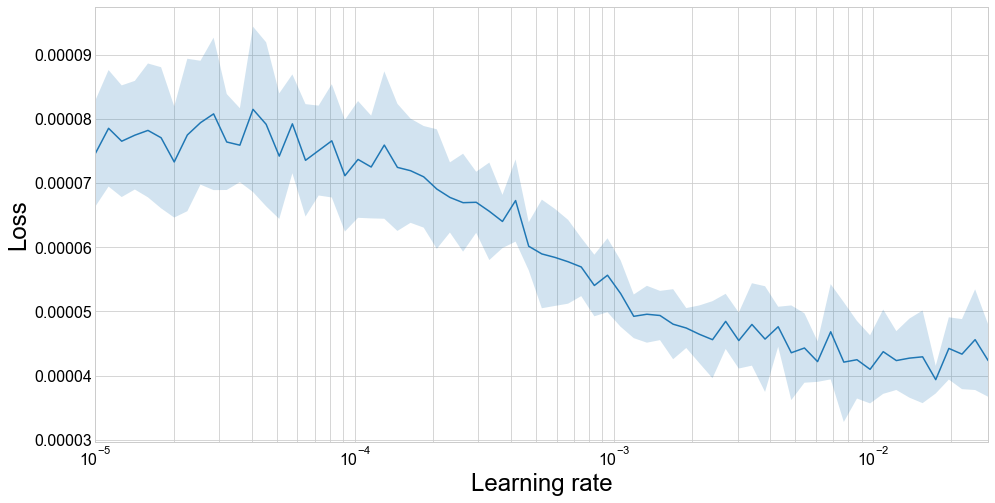

______________________________________



In [7]:
lr_finder = fold_lr_find(train_fy, get_res_model, model_params, train_params,
                         lr_bounds=[1e-5,1e-1], train_on_weights=True, verbose=0)

2 classes found, running in binary mode



/Users/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.111935). Check your callbacks.
  % delta_t_median)
/Users/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.113311). Check your callbacks.
  % delta_t_median)
/Users/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.120162). Check your callbacks.
  % delta_t_median)
/Users/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.127692). Check your callbacks.
  % delta_t_median)
/Users/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.136775). Check your callbacks.
  % delta_t_med


______________________________________
Training finished
Cross-validation took 43.713s 


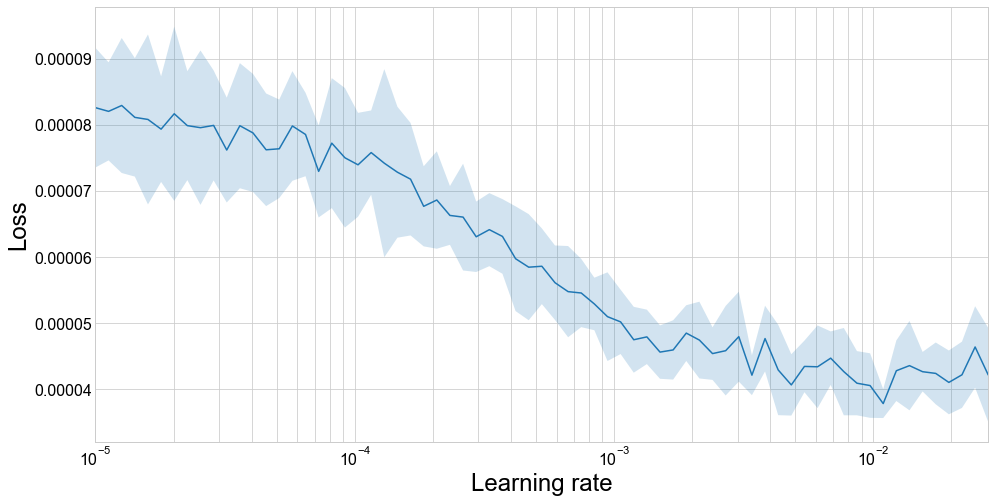

______________________________________



In [9]:
lr_finder = fold_lr_find(train_fy, get_res_model, model_params, train_params,
                         lr_bounds=[1e-5,1e-1], train_on_weights=True, verbose=0)

## Train classifier

In [10]:
model_gen_params = {**model_params, 'compile_args':{**compile_args, 'lr':8e-3}}
use_callbacks = {'CosAnnealLR':{'reverse':False, 'cycle_mult':2, 'scale':1, 'redux_decay':True}}
ams_args = {'n_total':250000, 'br':10, 'delta_b':0}
plots = ['history', 'lr']

Training using weights
Training model 1 / 10
Using cosine LR annealing
2 classes found, running in binary mode



/Users/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.431569). Check your callbacks.
  % delta_t_median)


Saving snapshot 1
1 New best found: 3.6195216508349404e-05
2 New best found: 3.51001736431499e-05
Saving snapshot 2
3 New best found: 3.392914115684107e-05
6 New best found: 3.328068508708384e-05
Saving snapshot 3
7 New best found: 3.2873689936241136e-05
13 New best found: 3.247208943794249e-05
14 New best found: 3.2406447222456335e-05
Saving snapshot 4
15 New best found: 3.2369901180209125e-05
25 New best found: 3.21646674288786e-05
26 New best found: 3.211835500405869e-05
27 New best found: 3.2054855200112795e-05
28 New best found: 3.195980064338073e-05
29 New best found: 3.185514713259181e-05
Saving snapshot 5
31 New best found: 3.18530408636434e-05
54 New best found: 3.167867284937529e-05
56 New best found: 3.155761589514441e-05
58 New best found: 3.15252897067694e-05
59 New best found: 3.148755423608236e-05
Saving snapshot 6
63 New best found: 3.147969018609729e-05
107 New best found: 3.145671835227404e-05
110 New best found: 3.1390489966725e-05
114 New best found: 3.1390306737739

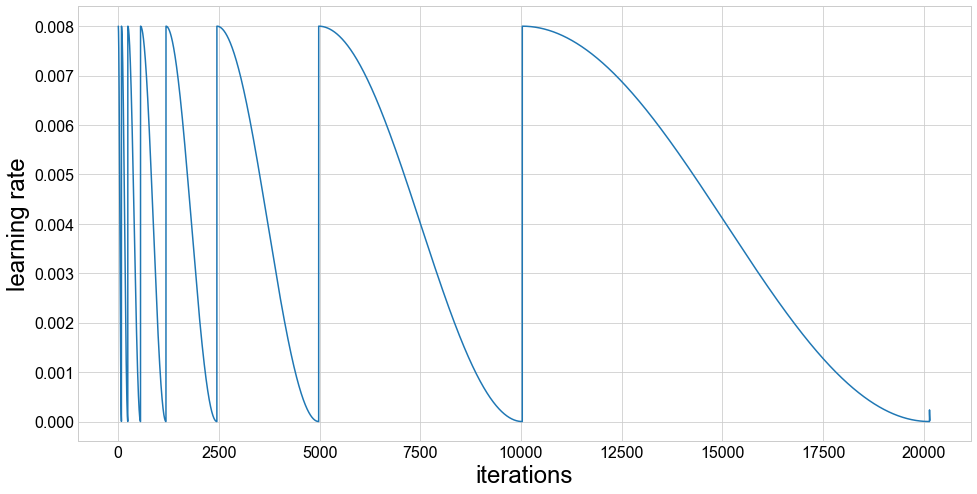

Fold took 334.608s

Training model 2 / 10
Using cosine LR annealing


/Users/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.449131). Check your callbacks.
  % delta_t_median)


Saving snapshot 1
1 New best found: 3.801599243452074e-05
2 New best found: 3.785061732924078e-05
Saving snapshot 2
3 New best found: 3.576772999804234e-05
5 New best found: 3.545824022803572e-05
6 New best found: 3.455449589309865e-05
Saving snapshot 3
7 New best found: 3.426793904363876e-05
12 New best found: 3.4079077527712796e-05
13 New best found: 3.3936824591364715e-05
14 New best found: 3.372083441936411e-05
Saving snapshot 4
26 New best found: 3.3630399084358945e-05
27 New best found: 3.346886159706628e-05
28 New best found: 3.341535097715678e-05
29 New best found: 3.328483293880709e-05
30 New best found: 3.3228797755145933e-05
Saving snapshot 5
31 New best found: 3.322656693198951e-05
50 New best found: 3.3130526242166525e-05
52 New best found: 3.307877442712197e-05
56 New best found: 3.302106017290498e-05
57 New best found: 3.3015145767421925e-05
58 New best found: 3.2935018732678144e-05
59 New best found: 3.2901920512813376e-05
60 New best found: 3.2890260389103785e-05
61 Ne

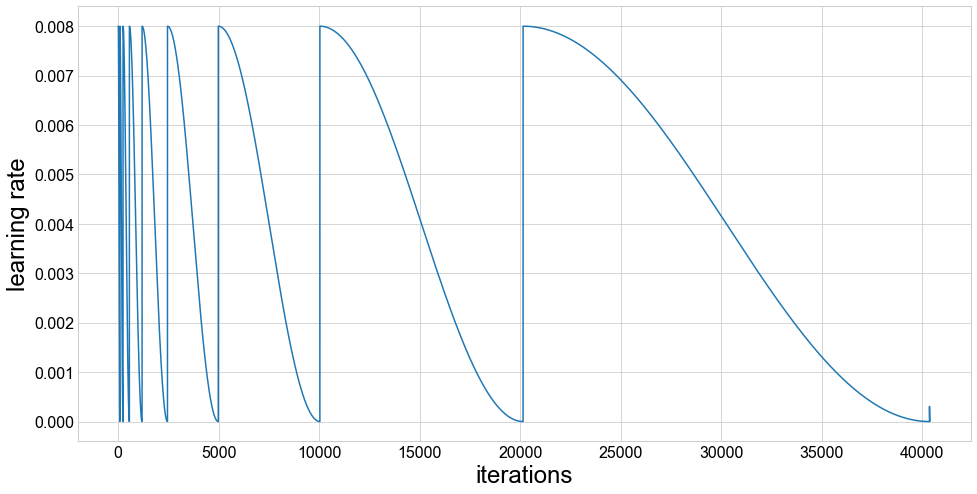

Fold took 684.777s

Training model 3 / 10
Using cosine LR annealing


/Users/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (1.014394). Check your callbacks.
  % delta_t_median)
/Users/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.507771). Check your callbacks.
  % delta_t_median)


Saving snapshot 1
1 New best found: 3.6696529072579064e-05
2 New best found: 3.6148303695437674e-05
Saving snapshot 2
3 New best found: 3.459003084313359e-05
6 New best found: 3.361497933513631e-05
Saving snapshot 3
7 New best found: 3.34257441033655e-05
12 New best found: 3.320701966459842e-05
13 New best found: 3.272731543347004e-05
14 New best found: 3.251767888023265e-05
Saving snapshot 4
15 New best found: 3.250087405517372e-05
26 New best found: 3.2409331470753414e-05
27 New best found: 3.222100119962659e-05
28 New best found: 3.209429042933663e-05
29 New best found: 3.208064118825919e-05
30 New best found: 3.203322921153782e-05
Saving snapshot 5
53 New best found: 3.201135422014822e-05
55 New best found: 3.186823015174052e-05
58 New best found: 3.176632488109947e-05
59 New best found: 3.173926937623656e-05
60 New best found: 3.1726437720734876e-05
61 New best found: 3.170840111650822e-05
62 New best found: 3.170265149683255e-05
Saving snapshot 6
103 New best found: 3.16554778608

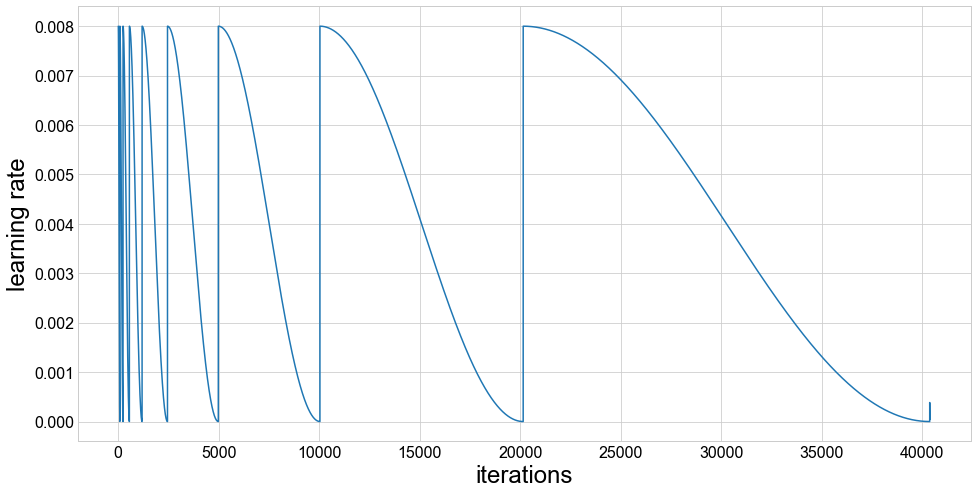

Fold took 712.252s

Training model 4 / 10
Using cosine LR annealing


/Users/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.991917). Check your callbacks.
  % delta_t_median)
/Users/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.496557). Check your callbacks.
  % delta_t_median)


Saving snapshot 1
1 New best found: 3.638332118995525e-05
2 New best found: 3.548221961241128e-05
Saving snapshot 2
3 New best found: 3.429337723341524e-05
6 New best found: 3.393456887274355e-05
Saving snapshot 3
7 New best found: 3.340362388312909e-05
11 New best found: 3.33533012868161e-05
12 New best found: 3.3218796394026144e-05
13 New best found: 3.2797447301042266e-05
14 New best found: 3.2582653109786495e-05
Saving snapshot 4
15 New best found: 3.253209565139311e-05
24 New best found: 3.252734775719183e-05
26 New best found: 3.247608135343068e-05
27 New best found: 3.229723695669332e-05
29 New best found: 3.2122607460977734e-05
30 New best found: 3.209633592525466e-05
Saving snapshot 5
31 New best found: 3.207816384382823e-05
51 New best found: 3.20427892935452e-05
52 New best found: 3.2027975517599056e-05
54 New best found: 3.1939490830629735e-05
56 New best found: 3.180125756414465e-05
59 New best found: 3.178270352681966e-05
60 New best found: 3.1759798706208436e-05
62 New b

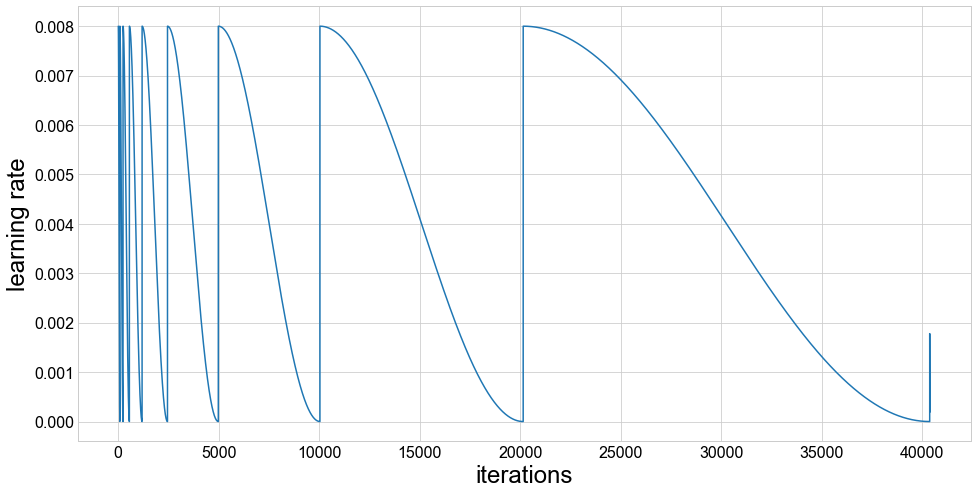

Fold took 687.165s

Training model 5 / 10
Using cosine LR annealing


/Users/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (1.077093). Check your callbacks.
  % delta_t_median)
/Users/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.539236). Check your callbacks.
  % delta_t_median)


Saving snapshot 1
1 New best found: 3.772016710281605e-05
Saving snapshot 2
3 New best found: 3.558118434157222e-05
Saving snapshot 3
7 New best found: 3.451983609993476e-05
12 New best found: 3.4510211968154183e-05
13 New best found: 3.399894477770431e-05
14 New best found: 3.378211433300749e-05
Saving snapshot 4
25 New best found: 3.364659918734105e-05
28 New best found: 3.3417054417077454e-05
29 New best found: 3.3347672007221263e-05
30 New best found: 3.3324954882846216e-05
Saving snapshot 5
31 New best found: 3.3320479607209564e-05
51 New best found: 3.3282686909660694e-05
52 New best found: 3.3273587524308824e-05
53 New best found: 3.321278224539128e-05
54 New best found: 3.307653511583339e-05
55 New best found: 3.304201557912165e-05
56 New best found: 3.299270669958787e-05
58 New best found: 3.2948866345395796e-05
59 New best found: 3.2921401568455624e-05
60 New best found: 3.2908888938254675e-05
62 New best found: 3.289941978437128e-05
Saving snapshot 6
103 New best found: 3.28

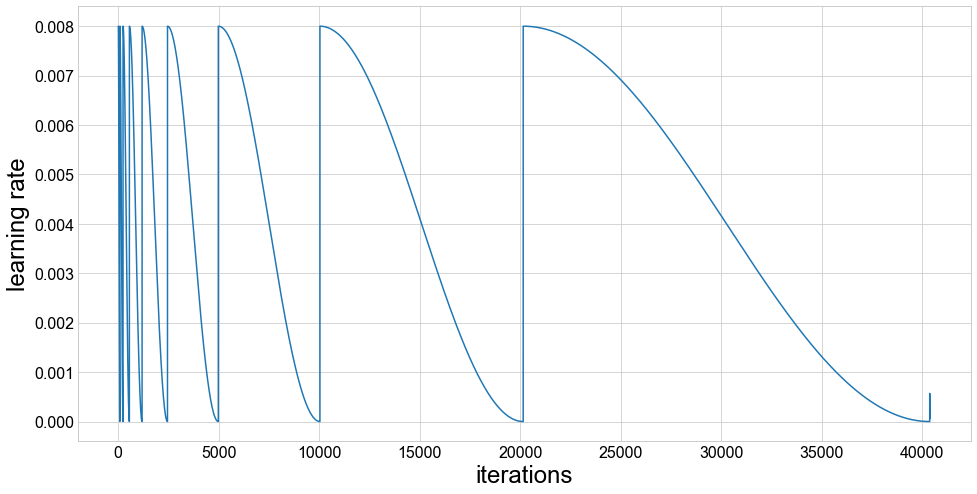

Fold took 700.015s

Training model 6 / 10
Using cosine LR annealing


/Users/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (1.111500). Check your callbacks.
  % delta_t_median)
/Users/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.556319). Check your callbacks.
  % delta_t_median)


Saving snapshot 1
1 New best found: 3.752095617090141e-05
2 New best found: 3.712701076310798e-05
Saving snapshot 2
3 New best found: 3.522969451163401e-05
6 New best found: 3.497871394223258e-05
Saving snapshot 3
7 New best found: 3.4609164533814355e-05
11 New best found: 3.439608575046044e-05
12 New best found: 3.4052736617371394e-05
13 New best found: 3.369976780534468e-05
14 New best found: 3.3595266324571736e-05
Saving snapshot 4
15 New best found: 3.355387503360164e-05
25 New best found: 3.340602210745351e-05
26 New best found: 3.319897027467265e-05
27 New best found: 3.319659350438818e-05
28 New best found: 3.31354170010074e-05
29 New best found: 3.311048581591221e-05
30 New best found: 3.3041499514134324e-05
Saving snapshot 5
31 New best found: 3.302959468780591e-05
48 New best found: 3.294776947194094e-05
52 New best found: 3.269975915415741e-05
56 New best found: 3.2662925141539304e-05
57 New best found: 3.26334523866696e-05
Saving snapshot 6
98 New best found: 3.253961144024

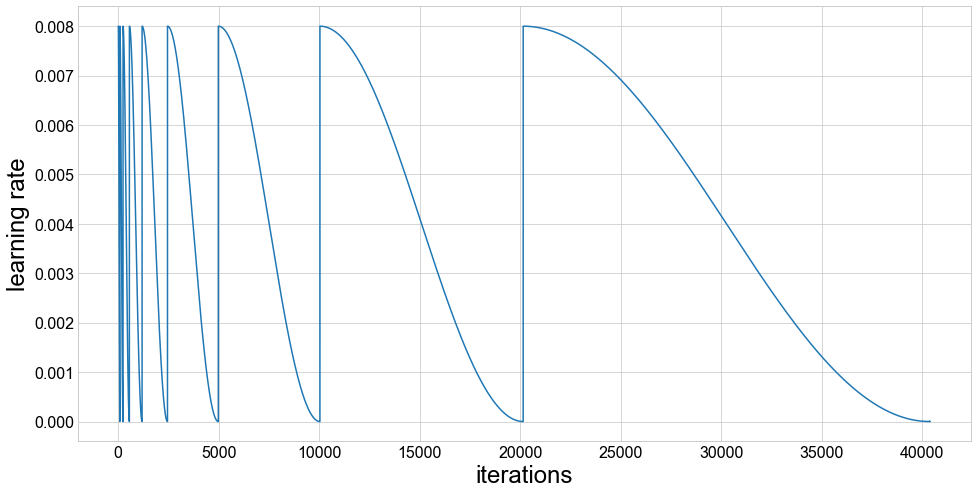

Fold took 719.084s

Training model 7 / 10
Using cosine LR annealing


/Users/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (1.160493). Check your callbacks.
  % delta_t_median)
/Users/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.580872). Check your callbacks.
  % delta_t_median)


Saving snapshot 1
1 New best found: 3.634852757301557e-05
2 New best found: 3.624320650178667e-05
Saving snapshot 2
3 New best found: 3.4509924024997e-05
5 New best found: 3.427438201678968e-05
6 New best found: 3.3760234700554986e-05
Saving snapshot 3
7 New best found: 3.345563709621038e-05
12 New best found: 3.319666834627923e-05
13 New best found: 3.2859606324791995e-05
14 New best found: 3.268647305116289e-05
Saving snapshot 4
15 New best found: 3.263600350981764e-05
24 New best found: 3.256081110355725e-05
27 New best found: 3.2470828651848195e-05
28 New best found: 3.244817135340767e-05
29 New best found: 3.2292239111659904e-05
30 New best found: 3.225769636678749e-05
Saving snapshot 5
49 New best found: 3.22566363998001e-05
51 New best found: 3.2174198150057445e-05
53 New best found: 3.212752841901336e-05
55 New best found: 3.212490526462354e-05
56 New best found: 3.1903992426821525e-05
59 New best found: 3.187196130771518e-05
60 New best found: 3.185056382770746e-05
61 New best

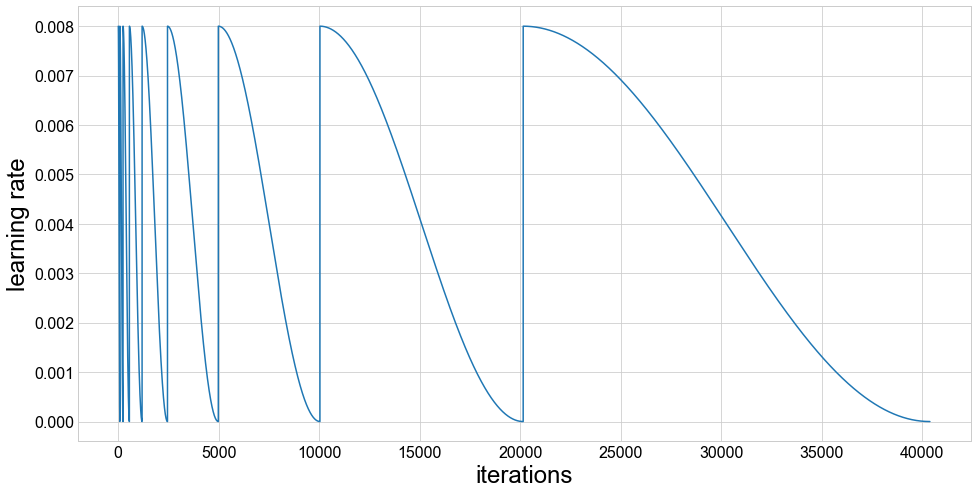

Fold took 841.138s

Training model 8 / 10
Using cosine LR annealing


/Users/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (1.218326). Check your callbacks.
  % delta_t_median)
/Users/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.609840). Check your callbacks.
  % delta_t_median)


Saving snapshot 1
1 New best found: 3.5226672185293664e-05
Saving snapshot 2
3 New best found: 3.369252886074044e-05
6 New best found: 3.299079146512783e-05
Saving snapshot 3
7 New best found: 3.2874989012665646e-05
12 New best found: 3.2401531224529166e-05
13 New best found: 3.22809276492674e-05
14 New best found: 3.2193696916697306e-05
Saving snapshot 4
15 New best found: 3.2188730218747825e-05
23 New best found: 3.190064275884865e-05
27 New best found: 3.187874988944634e-05
28 New best found: 3.1780459213607235e-05
29 New best found: 3.156800989572485e-05
Saving snapshot 5
31 New best found: 3.155118936636329e-05
48 New best found: 3.142760212631269e-05
50 New best found: 3.141014852224227e-05
51 New best found: 3.140145691272686e-05
54 New best found: 3.1203488932392626e-05
56 New best found: 3.114032685968936e-05
61 New best found: 3.1125581400859644e-05
62 New best found: 3.1120672720931946e-05
Saving snapshot 6
102 New best found: 3.1092687412881296e-05
106 New best found: 3.107

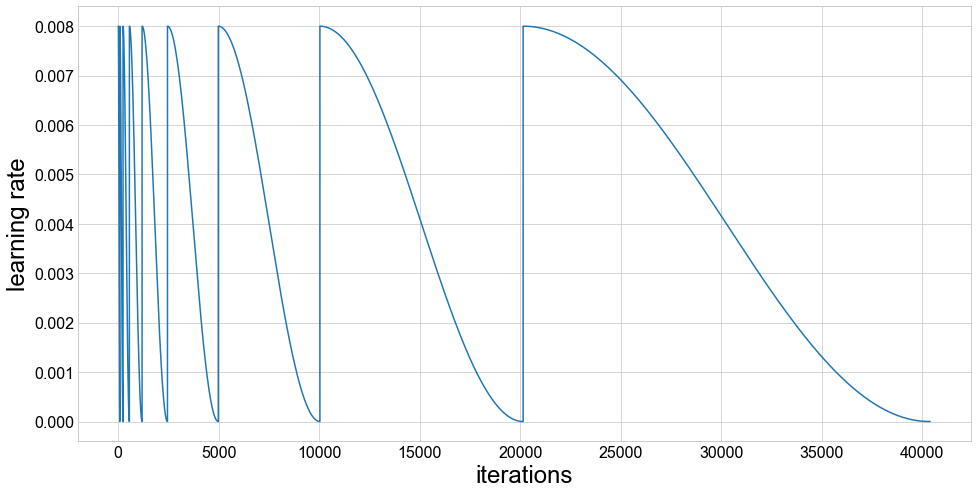

Fold took 802.450s

Training model 9 / 10
Using cosine LR annealing


/Users/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (1.266879). Check your callbacks.
  % delta_t_median)
/Users/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.634055). Check your callbacks.
  % delta_t_median)


Saving snapshot 1
1 New best found: 3.6751198233105245e-05
Saving snapshot 2
3 New best found: 3.5484941012691706e-05
6 New best found: 3.402086907299235e-05
Saving snapshot 3
7 New best found: 3.3867156889755276e-05
12 New best found: 3.371210052719107e-05
13 New best found: 3.348142177783302e-05
14 New best found: 3.3415092655923215e-05
Saving snapshot 4
15 New best found: 3.3350839558261214e-05
24 New best found: 3.324236381886294e-05
26 New best found: 3.308990692312364e-05
28 New best found: 3.296414032156463e-05
29 New best found: 3.28007165408053e-05
30 New best found: 3.2782586271787294e-05
Saving snapshot 5
52 New best found: 3.274245162247098e-05
53 New best found: 3.273535368498415e-05
54 New best found: 3.267157900700113e-05
55 New best found: 3.2646511436178115e-05
56 New best found: 3.2626932791026775e-05
58 New best found: 3.258728057262488e-05
59 New best found: 3.257550502603408e-05
60 New best found: 3.2551143255113854e-05
61 New best found: 3.253660633054096e-05
Savi

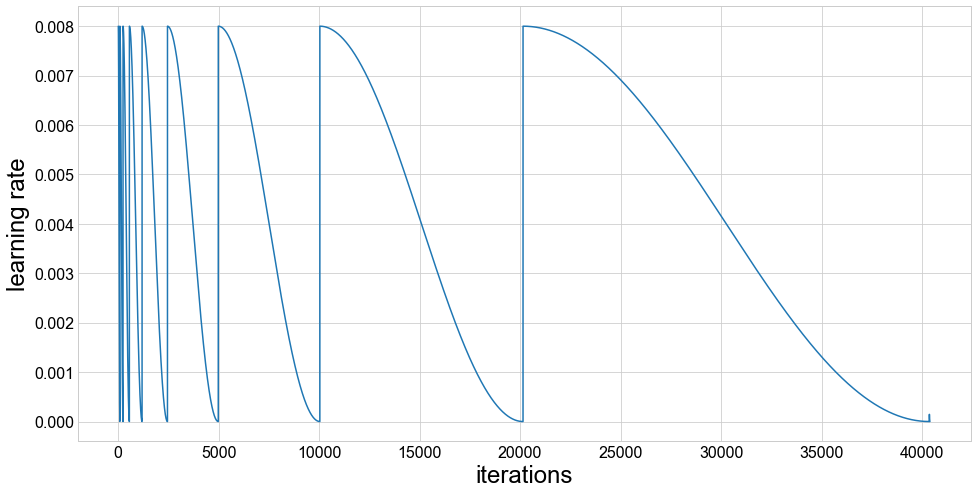

Fold took 835.616s

Training model 10 / 10
Using cosine LR annealing


/Users/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (1.321108). Check your callbacks.
  % delta_t_median)
/Users/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.661198). Check your callbacks.
  % delta_t_median)


Saving snapshot 1
1 New best found: 3.6394478560061375e-05
2 New best found: 3.52155588841255e-05
Saving snapshot 2
3 New best found: 3.411851297602245e-05
5 New best found: 3.407870856342128e-05
6 New best found: 3.2881528709644715e-05
Saving snapshot 3
7 New best found: 3.278746931695153e-05
13 New best found: 3.2476212358955547e-05
14 New best found: 3.238630258812116e-05
Saving snapshot 4
15 New best found: 3.233480908201875e-05
24 New best found: 3.2265455501078625e-05
25 New best found: 3.210263549735775e-05
27 New best found: 3.206653867227339e-05
28 New best found: 3.192718117288943e-05
29 New best found: 3.189685251044354e-05
30 New best found: 3.184517286238812e-05
Saving snapshot 5
31 New best found: 3.182804393559779e-05
50 New best found: 3.181299429649501e-05
51 New best found: 3.172198135914139e-05
54 New best found: 3.168242343806622e-05
56 New best found: 3.1617638134786284e-05
57 New best found: 3.1546324069398547e-05
58 New best found: 3.150637116112008e-05
60 New be

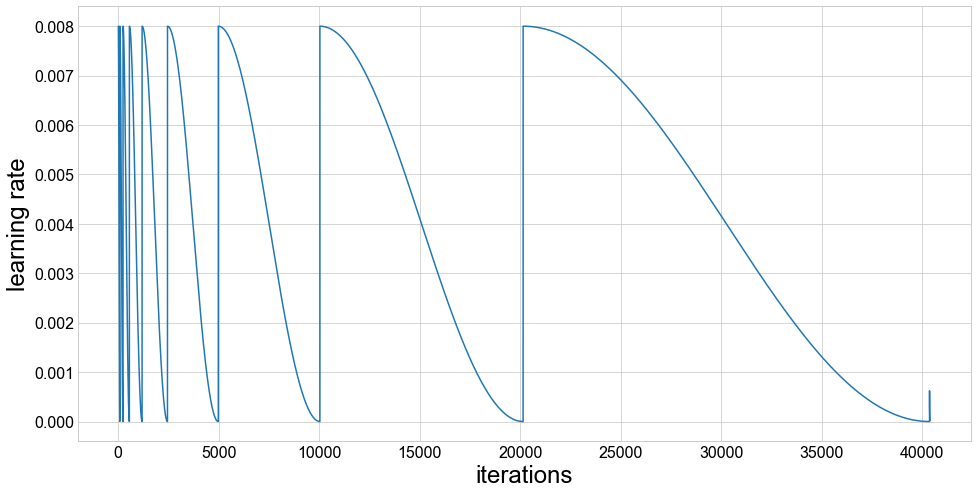

Fold took 851.929s


______________________________________
Training finished
Cross-validation took 7169.361s 


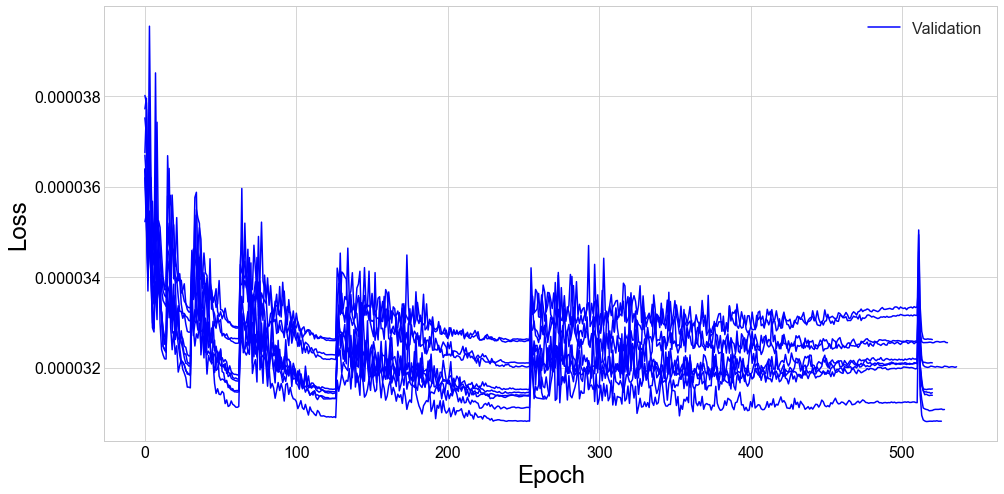

Mean loss = 3.17e-05 +- 2e-07
Mean wAUC = 0.0629 +- 0.0007
Mean AUC = 0.0983 +- 0.0005
Mean AMS = 4.04 +- 0.07
Mean cut = 0.966 +- 0.005
______________________________________



<Figure size 432x288 with 0 Axes>

In [11]:
results, histories, cycle_losses = fold_train_model(train_fy, n_models,
                                                    model_gen_params=model_gen_params, model_gen=get_res_model,
                                                    train_params=train_params, train_on_weights=True,
                                                    use_callbacks=use_callbacks, ams_args=ams_args,
                                                    max_epochs=max_epochs, patience=patience,
                                                    verbose=1, plots=plots)

## Construct ensemble

In [4]:
with open('train_weights/results_file.pkl', 'rb') as fin:   
    results = pickle.load(fin)
with open('train_weights/cycle_file.pkl', 'rb') as fin:   
    cycle_losses = pickle.load(fin)

In [5]:
ensemble, weights = assemble_ensemble(results, 10)

Choosing ensemble by loss
Model 0 is 7 with loss = 3.080704480871576e-05
Model 1 is 9 with loss = 3.10443762728908e-05
Model 2 is 0 with loss = 3.130607152270386e-05
Model 3 is 3 with loss = 3.135932203098435e-05
Model 4 is 2 with loss = 3.1426099241413414e-05
Model 5 is 6 with loss = 3.151056450297716e-05
Model 6 is 8 with loss = 3.200343643620727e-05
Model 7 is 5 with loss = 3.209825960355672e-05
Model 8 is 1 with loss = 3.2548580167349425e-05
Model 9 is 4 with loss = 3.259006616135593e-05


## Response on validation data without TTA

In [6]:
val_fy = FoldYielder(h5py.File(DATA_PATH/'val.hdf5', "r+"))

In [7]:
fold_ensemble_predict(ensemble, weights, val_fy, ensemble_size=ensemble_size, verbose=1)

Predicting fold 1 out of 10
Prediction took 0.000526532077199954s per sample

Predicting fold 2 out of 10
Prediction took 0.00016910657260013978s per sample

Predicting fold 3 out of 10
Prediction took 0.00016772287499989034s per sample

Predicting fold 4 out of 10
Prediction took 0.00017051134140056093s per sample

Predicting fold 5 out of 10
Prediction took 0.00017060202259963262s per sample

Predicting fold 6 out of 10
Prediction took 0.00017091041500025313s per sample

Predicting fold 7 out of 10
Prediction took 0.00016809179139963817s per sample

Predicting fold 8 out of 10
Prediction took 0.00018323909179962357s per sample

Predicting fold 9 out of 10
Prediction took 0.00017795647159946383s per sample

Predicting fold 10 out of 10
Prediction took 0.0001731193957995856s per sample



In [8]:
val_df = convert_to_df(val_fy.source)

50000 candidates loaded


In [9]:
print('Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(val_df.gen_target, val_df.pred_class),
                                                           roc_auc_score(val_df.gen_target, val_df.pred_class, sample_weight=val_df.gen_weight)))

Testing ROC AUC: unweighted 0.9034911732008611, weighted 0.9362578930588625


/Users/giles/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/Users/giles/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6499: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


Best cut at 0.9509764082796939 corresponds to AMS of 3.836743769974991
Maximum AMS for data is 3.900888125002555 at cut of 0.9550383687019348
CPU times: user 13.8 s, sys: 58.3 ms, total: 13.9 s
Wall time: 14 s


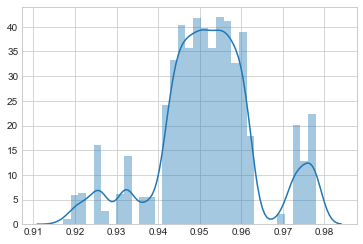

In [10]:
%%time
cut_kde = kde_optimise_cut(val_df, top_perc=0.05, br=10, w_factor=250000/50000)

Mean cut at 0.951759 corresponds to AMS of 3.8400796169210345
Maximum AMS for data is 3.900888125002555 at cut of 0.9550383687019348
CPU times: user 85.4 ms, sys: 11.7 ms, total: 97.1 ms
Wall time: 65.1 ms


/Users/giles/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/Users/giles/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6499: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


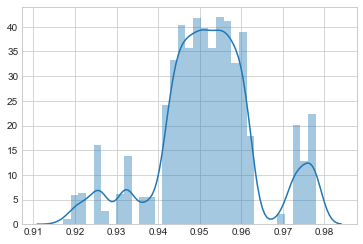

In [11]:
%%time
cut_mean = mean_optimise_cut(val_df, top_perc=0.05, br=10, w_factor=250000/50000)

## Response on validation data with TTA

In [12]:
val_fy = HEPAugFoldYielder(train_feats, h5py.File(DATA_PATH/'val.hdf5', "r+"), rot_mult=2)

Augmenting via phi rotations
Augmenting via y flips
Augmenting via longitunidnal flips
Total augmentation multiplicity is 8


In [13]:
fold_ensemble_predict(ensemble, weights, val_fy, pred_name='pred_TTA', ensemble_size=ensemble_size, verbose=1)

Predicting fold 1 out of 10
Prediction took 0.001450934645599773s per sample

Predicting fold 2 out of 10
Prediction took 0.0014104020634003974s per sample

Predicting fold 3 out of 10
Prediction took 0.0014063441956001044s per sample

Predicting fold 4 out of 10
Prediction took 0.0014377985748003994s per sample

Predicting fold 5 out of 10
Prediction took 0.001444520409800316s per sample

Predicting fold 6 out of 10
Prediction took 0.0014129344532004325s per sample

Predicting fold 7 out of 10
Prediction took 0.001592855004000012s per sample

Predicting fold 8 out of 10
Prediction took 0.0016551819662003254s per sample

Predicting fold 9 out of 10
Prediction took 0.0014059601430002659s per sample

Predicting fold 10 out of 10
Prediction took 0.0014423477946002095s per sample



In [14]:
val_df_tta = convert_to_df(val_fy.source, pred_name='pred_TTA')

50000 candidates loaded


In [15]:
print('Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(val_df_tta.gen_target, val_df_tta.pred_class),
                                                           roc_auc_score(val_df_tta.gen_target, val_df_tta.pred_class, sample_weight=val_df_tta.gen_weight)))

Testing ROC AUC: unweighted 0.9035402294718053, weighted 0.9363004571401429


/Users/giles/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/Users/giles/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6499: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


Best cut at 0.9572894440160261 corresponds to AMS of 3.822400827388313
Maximum AMS for data is 3.896838244481164 at cut of 0.9540070295333862
CPU times: user 14 s, sys: 48 ms, total: 14.1 s
Wall time: 14.1 s


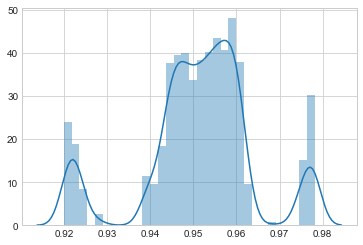

In [16]:
%%time
cut_kde_tta = kde_optimise_cut(val_df_tta, top_perc=0.05, br=10, w_factor=250000/50000)

Mean cut at 0.95123225 corresponds to AMS of 3.812769579839011
Maximum AMS for data is 3.896838244481164 at cut of 0.9540070295333862
CPU times: user 101 ms, sys: 9.88 ms, total: 111 ms
Wall time: 55.8 ms


/Users/giles/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/Users/giles/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6499: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


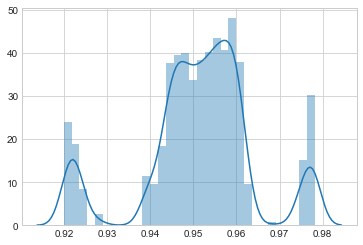

In [17]:
%%time
cut_mean_tta = mean_optimise_cut(val_df_tta, top_perc=0.05, br=10, w_factor=250000/50000)

# Test scoring - Without TTA

In [18]:
test_fy = FoldYielder(h5py.File(DATA_PATH/'testing.hdf5', "r+"))

In [19]:
%%time
fold_ensemble_predict(ensemble, weights, test_fy, ensemble_size=ensemble_size, verbose=1)

Predicting fold 1 out of 10
Prediction took 0.00017202920883633356s per sample

Predicting fold 2 out of 10
Prediction took 0.0001680289905636693s per sample

Predicting fold 3 out of 10
Prediction took 0.0001687627682545016s per sample

Predicting fold 4 out of 10
Prediction took 0.0001684272312363398s per sample

Predicting fold 5 out of 10
Prediction took 0.00018206684434546994s per sample

Predicting fold 6 out of 10
Prediction took 0.00017010600396361869s per sample

Predicting fold 7 out of 10
Prediction took 0.0001741605603818078s per sample

Predicting fold 8 out of 10
Prediction took 0.00016621819514548407s per sample

Predicting fold 9 out of 10
Prediction took 0.0001637971808727095s per sample

Predicting fold 10 out of 10
Prediction took 0.00016455905027270835s per sample

CPU times: user 2min 52s, sys: 43.4 s, total: 3min 35s
Wall time: 1min 33s


In [20]:
score_test_data(test_fy.source, cut_kde)

Public:Private AMS: 3.764601914109629 : 3.8070187514785707


(3.764601914109629, 3.8070187514785707)

In [21]:
score_test_data(test_fy.source, cut_mean)

Public:Private AMS: 3.7527924187314916 : 3.8044231598199905


(3.7527924187314916, 3.8044231598199905)

# Test scoring - With TTA

In [25]:
test_fy = HEPAugFoldYielder(train_feats, h5py.File(DATA_PATH/'testing.hdf5', "r+"), rot_mult=2, random_rot=True)

Augmenting via phi rotations
Augmenting via y flips
Augmenting via longitunidnal flips
Total augmentation multiplicity is 8


In [26]:
%%time
fold_ensemble_predict(ensemble, weights, test_fy, pred_name='pred_TTA', ensemble_size=ensemble_size, verbose=1)

Predicting fold 1 out of 10
Prediction took 0.0013915725946181655s per sample

Predicting fold 2 out of 10
Prediction took 0.0013795331787272351s per sample

Predicting fold 3 out of 10
Prediction took 0.0013641373634545413s per sample

Predicting fold 4 out of 10
Prediction took 0.0013690941311636628s per sample

Predicting fold 5 out of 10
Prediction took 0.0013643634434727242s per sample

Predicting fold 6 out of 10
Prediction took 0.0013630989934727206s per sample

Predicting fold 7 out of 10
Prediction took 0.0013745236172000162s per sample

Predicting fold 8 out of 10
Prediction took 0.001366371490272749s per sample

Predicting fold 9 out of 10
Prediction took 0.0014386914835818143s per sample

Predicting fold 10 out of 10
Prediction took 0.0013887305471636038s per sample

CPU times: user 23min 10s, sys: 5min 47s, total: 28min 58s
Wall time: 12min 39s


In [27]:
score_test_data(test_fy.source, cut_kde_tta, pred_name='pred_TTA')

Public:Private AMS: 3.738278409833846 : 3.7889967804824476


(3.738278409833846, 3.7889967804824476)

In [28]:
score_test_data(test_fy.source, cut_mean_tta, pred_name='pred_TTA')

Public:Private AMS: 3.768062404152723 : 3.802570139995868


(3.768062404152723, 3.802570139995868)

# Save/Load

In [ ]:
name = "weights/Swish_CLR_TTA"

In [ ]:
saveEnsemble(name, ensemble, weights, compile_args, overwrite=1)

In [ ]:
ensemble, weights, compile_args, _, _ = loadEnsemble(name)